# Case Study (Predict Bankruptcy)
In this case study we are looking to predict bankruptcy for various companies, we are given 97 features including the target feature which is bankruptcy and 6800 observations. This study is an interesting one since bankruptcy is a nearly rare event in this study. In the exploratory section, I have looked at the following.

* distribution of features
* point biseral correlation between numerical and the binary target feature
* correlation between numerical features
* cleaned data as some features had mixed datatypes (str,float) 
* Custom outlier treatment


In [1]:
# installing packages
import sys
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "ggplot2"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt


# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import PrecisionRecallDisplay, precision_score,recall_score,confusion_matrix,f1_score
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance,
detect_outliers_iqr,plot_all_dist,treat_outliers,plot_all_scatter,
plot_scatter_high_corr
)

# setting display constraints
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

import warnings
warnings.filterwarnings("ignore")

## Reading Data
The dataset is contained in an excel (sheet name: data). After reading the data we use lowercase for feature names and remove special characters from them.

In [2]:
path = "../data/business_bankruptcy_prediction.xlsx"
data_sheet = "data"
target="bankruptcy"

data = read_xlsx(path=path, sheet_name=data_sheet)
data.columns = (data.columns.str.strip()
                .str.lower()
                .str.replace('¬•', '')
                .str.replace(" ","_")
                )
print(data.info(verbose=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Columns: 97 entries, roa(c)_before_interest_and_depreciation_before_interest to bankruptcy
dtypes: float64(91), int64(3), object(3)
memory usage: 5.0+ MB
None


## Missing Values 
We find that there are not many missing values in the data and so dropping rows will not result in a considerable smaller dataset.
We notice that we have 8 missing values in the data spread across 8 features.

In [3]:
check_missing(data=data)

There are in total 8 missing values in the data.
Following are the list of columns with their corresponding missing number of values.          
roa(b)_before_interest_and_depreciation_after_tax    1
realized_sales_gross_margin                          1
net_value_per_share_(c)                              1
per_share_net_profit_before_tax_(yuan_)              1
regular_net_profit_growth_rate                       1
net_value_growth_rate                                1
inventory_and_accounts_receivable/net_value          1
inventory/working_capital                            1
dtype: int64


In [4]:
data_nomsn = data.dropna(axis=0)
check_missing(data=data_nomsn)

There are in total 0 missing values in the data.


### Target Distribution
Bankruptcy features is highly imbalanced as there are only ~3% of cases of bankruptcy. This suggests during modelling we need apply different techniques to balance the data either by sampling or using hyperparameters and choose metric carefully.

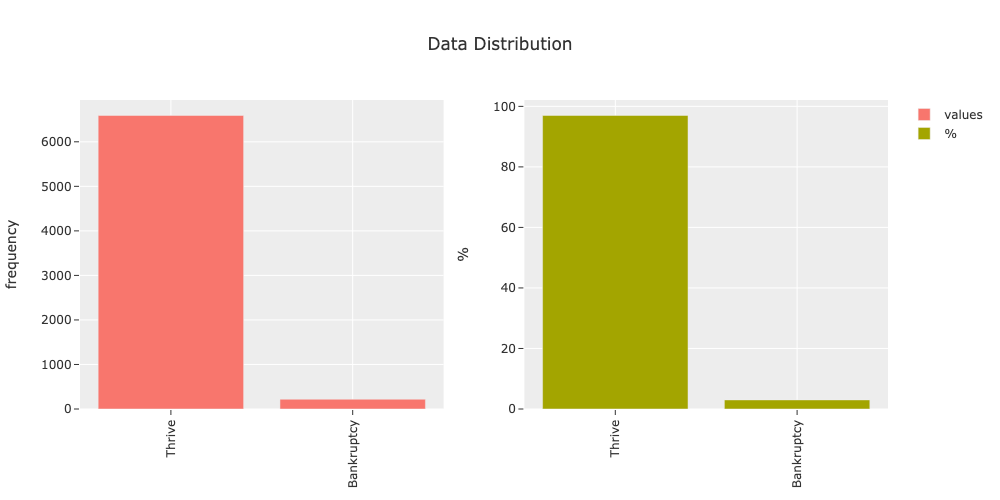

In [5]:
target_dist_num, target_dist_perc = get_dist(data=data_nomsn,col=target)
target_index = ["Thrive","Bankruptcy"]
plot_dist_bar(target_dist_num,target_dist_perc,title="Data Distribution", custom_index=True, 
index1=target_index,index2=target_index,show_static_image=True)

* **A limited company/private company** whose owners are legally responsible for its debts only to the extent of the amount of capital they invested.
* **Partnership(Limited partnerships)** have only one general partner with unlimited liability, and all other partners have limited liability.
* **LLP** are similar to limited partnerships, but give limited liability to every owner. 

**Takeaway:** We observe that we have higher number of partnership companies followed by private, while LLP is the lowest.

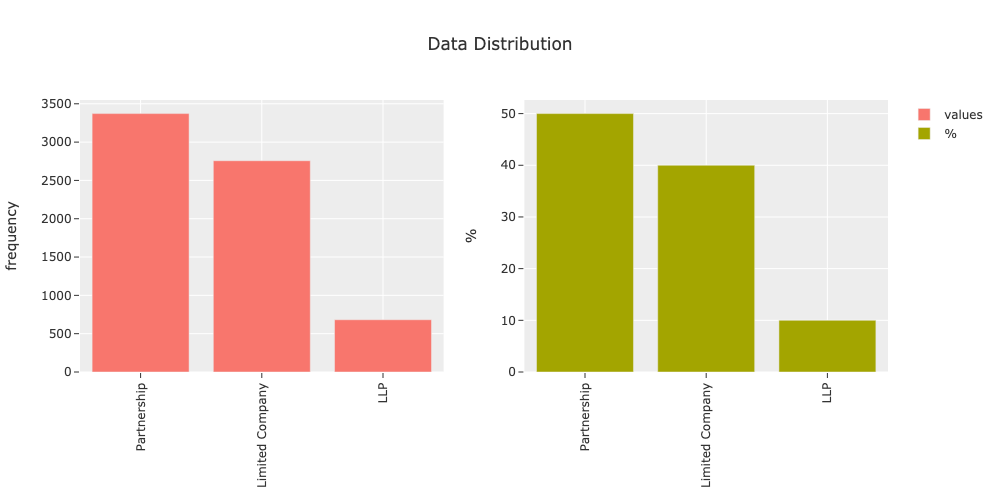

In [6]:
company_dist_num, company_dist_perc = get_dist(data=data_nomsn,col="company_type")
plot_dist_bar(company_dist_num,company_dist_perc,title="Data Distribution",show_static_image=True)


**Initial Takeaway**: The Distribution of company type wrt bankruptcy is equally distributed so it looks like the target doesnt have a direct impact.

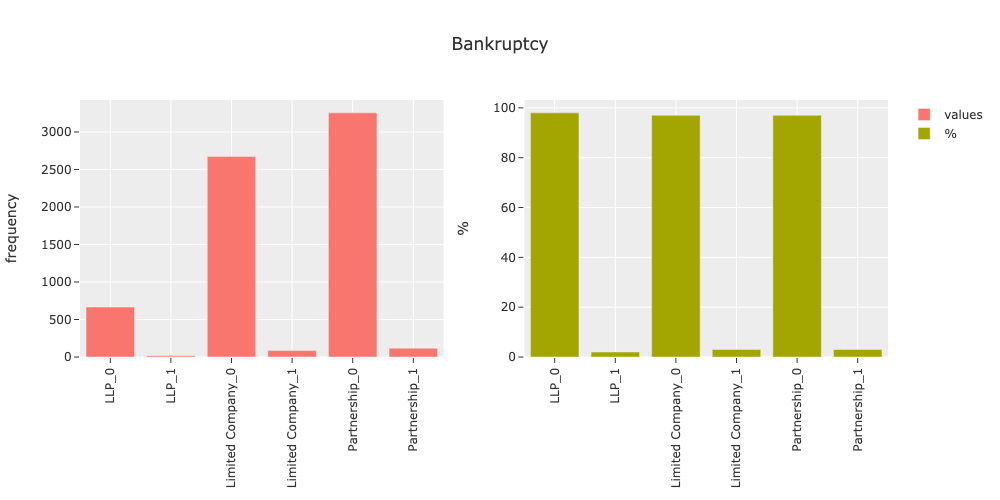

In [7]:
grp1=["company_type","bankruptcy"]

data_agg = (
    data_nomsn.groupby(grp1)
    .agg({"bankruptcy":"count"})
    )
data_agg["bankruptcy%"] = (data_agg
.groupby(level=0)
.apply(lambda x:round(x / float(x.sum()),2)))

data_agg = data_agg.rename(columns={"bankruptcy": "values", "bankruptcy%":"perc%"}).reset_index()
data_agg["index"] = data_agg["company_type"].astype(str)+"_"+data_agg["bankruptcy"].astype(str)

data_agg.set_index("index", inplace = True)
data_agg = data_agg.drop(grp1, axis=1)

comp_type_index = list(data_agg.index.values)
plot_dist_bar(data_agg["values"],data_agg["perc%"], title="Bankruptcy",show_static_image=True)

## Data Cleaning
* Constant features do not add value to the model as they no variance and thus we drop them from the data.
* We further need to convert incorrectly identified categorical features to numeric. This happens in the data as there are values of mixed datatypes in the feature.
* We also convert categorical features to pandas categorical class, they are highly optimsed form of datatype, which helps us reduce data size and are also compatible with many machine learning frameworks. 

In [8]:
data_variance  = data_nomsn.loc[:,data_nomsn.apply(pd.Series.nunique) != 1]
print(f"The feature/features {set(data_nomsn.columns).difference(set(data_variance.columns))} \
has/have no variance and are nearly constant and it has been dropped")

The feature/features {'net_income_flag'} has/have no variance and are nearly constant and it has been dropped


In [9]:
# fixing datatype issue, numerical assigned as categorical
print("listing categorical features","\n",data_variance.select_dtypes(include="object").columns)
potential_conversion_col = ["realized_sales_gross_margin", "allocation_rate_per_person"]

for c in potential_conversion_col:
    data_variance.loc[:,c] = (data_variance.loc[:,c]
    .replace(to_replace="(\d*\.?\d*)",value=0, regex=True)
    .astype(float))

listing categorical features 
 Index(['realized_sales_gross_margin', 'allocation_rate_per_person',
       'company_type'],
      dtype='object')


In [10]:
# convert object features to categoricals
cat_cols = list(data_variance.dtypes[data_variance.dtypes=="object"].index)
for c in cat_cols:
    data_variance.loc[:,c] = data_variance.loc[:,c].astype("category")


## Feature Engineering


In [11]:
X, y = (data_variance.drop(target,axis=1),data_variance[target])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=data_variance[target],random_state=42)

# train_dt = pd.concat([X_train,y_train],axis=1)
# test_dt = pd.concat([X_test,y_test],axis=1)

### Treating Outliers
As a first step we use Kurtosis to observe heavy tailed distributions, this metric is also very useful to detect outliers. Following that we will apply an appropriate transformation. The transformation could be `log(x)` or `log(1+x)` following which we will replace the outlier with either `median` or `90% quartile`.

I did find below that I was able to treat outliers that were away 3 times the IQR. The approach was to replace outliers on the left side of the distribution by the 5 percentile and on the right side by the 95 percentile. As a note, some of the distribution are a bit skewed and some exhibit bi-modal distribution, which suggests that 2 kinds of process at play.

*important note: The outlier transformation is performed on training and testing data separately to avoid data leakage.*

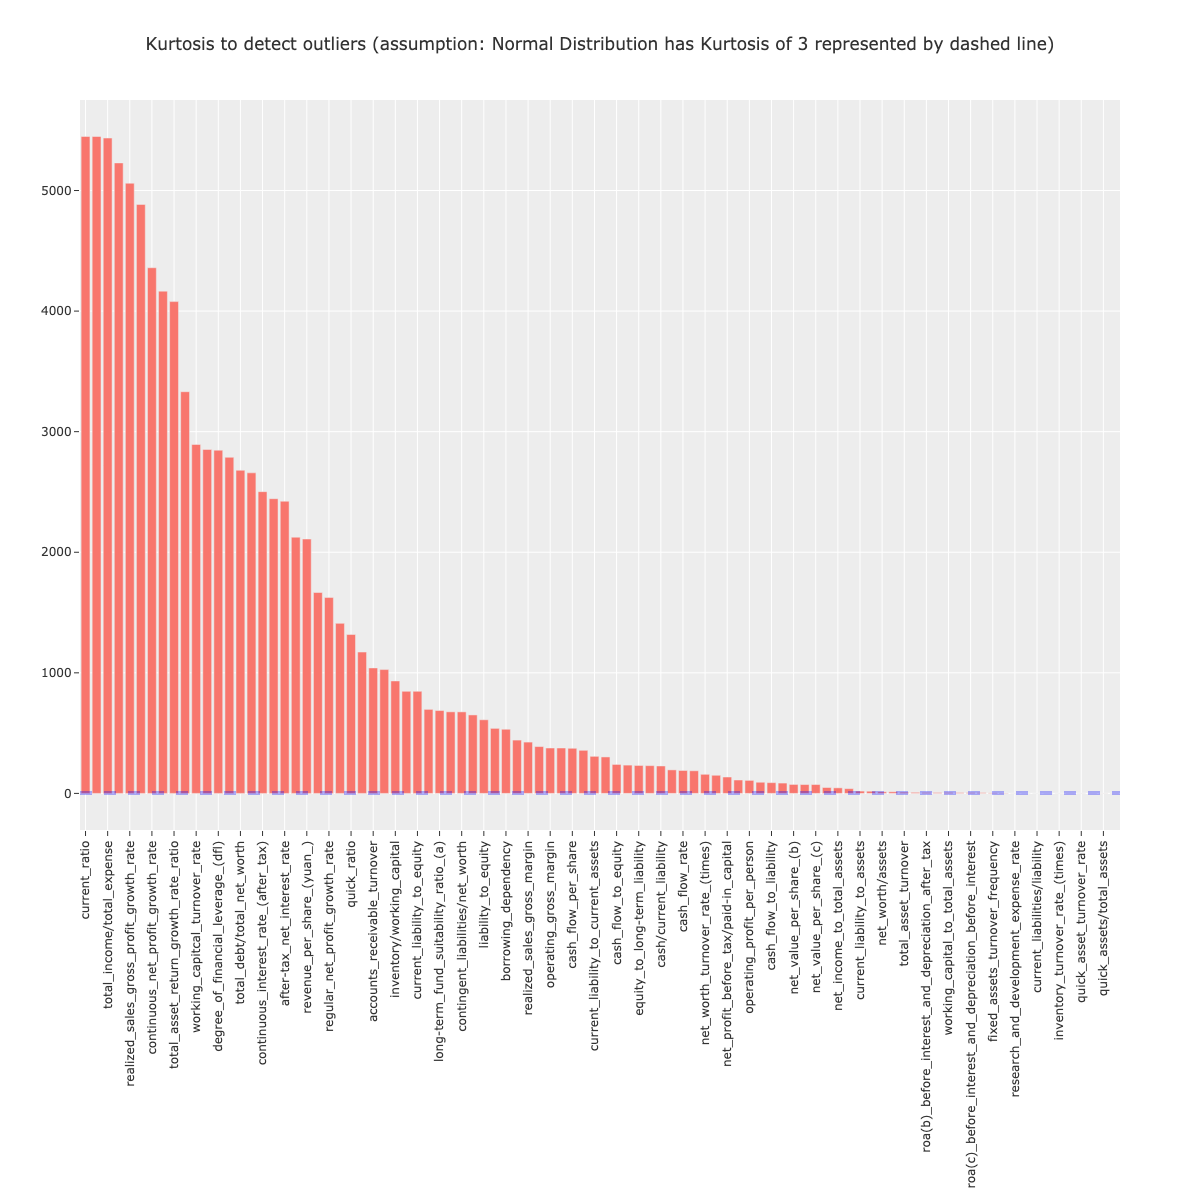

In [12]:
# Kurtosis
# Normal distribution generally has kurtosis of 3 
kurt_df = pd.DataFrame(X_train.select_dtypes(include=np.number).kurt(), columns=["kurtosis"]).reset_index()
kurt_df.columns = ["features","kurtosis"]
kurt_df = kurt_df.sort_values(by="kurtosis",ascending=False)

fig = go.Figure([go.Bar(x=kurt_df["features"], y=kurt_df["kurtosis"])])
fig.add_hline(y=3, 
              line_width=4, 
              line_dash="dash",
              line_color="blue",name="Gaussian Kurtosis")
fig.update_layout(width=1200, height=1200,xaxis_tickangle=-90, 
title="Kurtosis to detect outliers (assumption: Normal Distribution has Kurtosis of 3 represented by dashed line)")
fig.show("png")

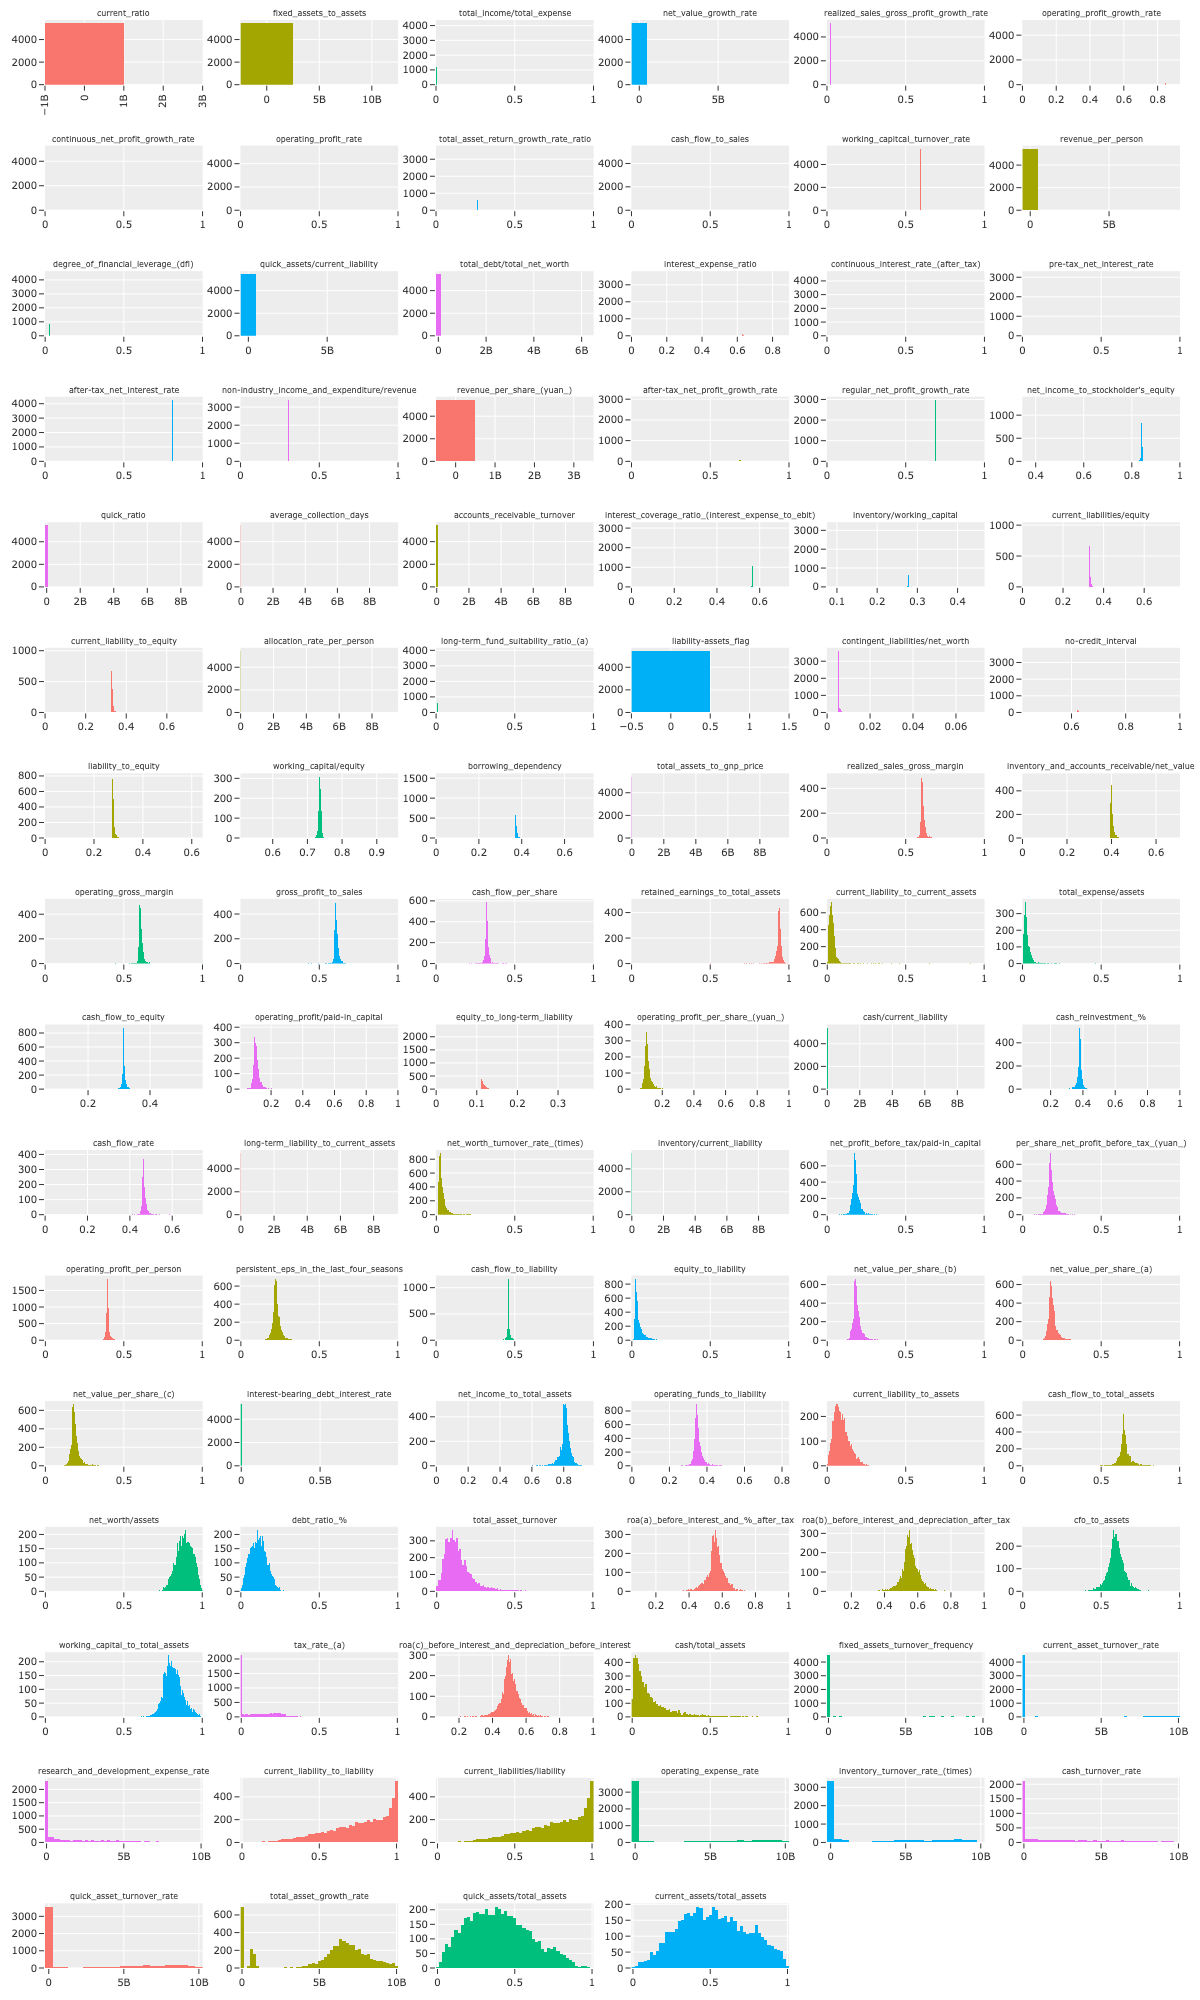

In [13]:
num_cols = list(kurt_df.features)
plot_all_dist(X_train, num_cols,show_static_image=True)


In [14]:
outliers_index = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 
25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
51, 53, 54, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 81]


In [15]:
num_cols_array = np.array(num_cols)
outliers_cols = num_cols_array[outliers_index]

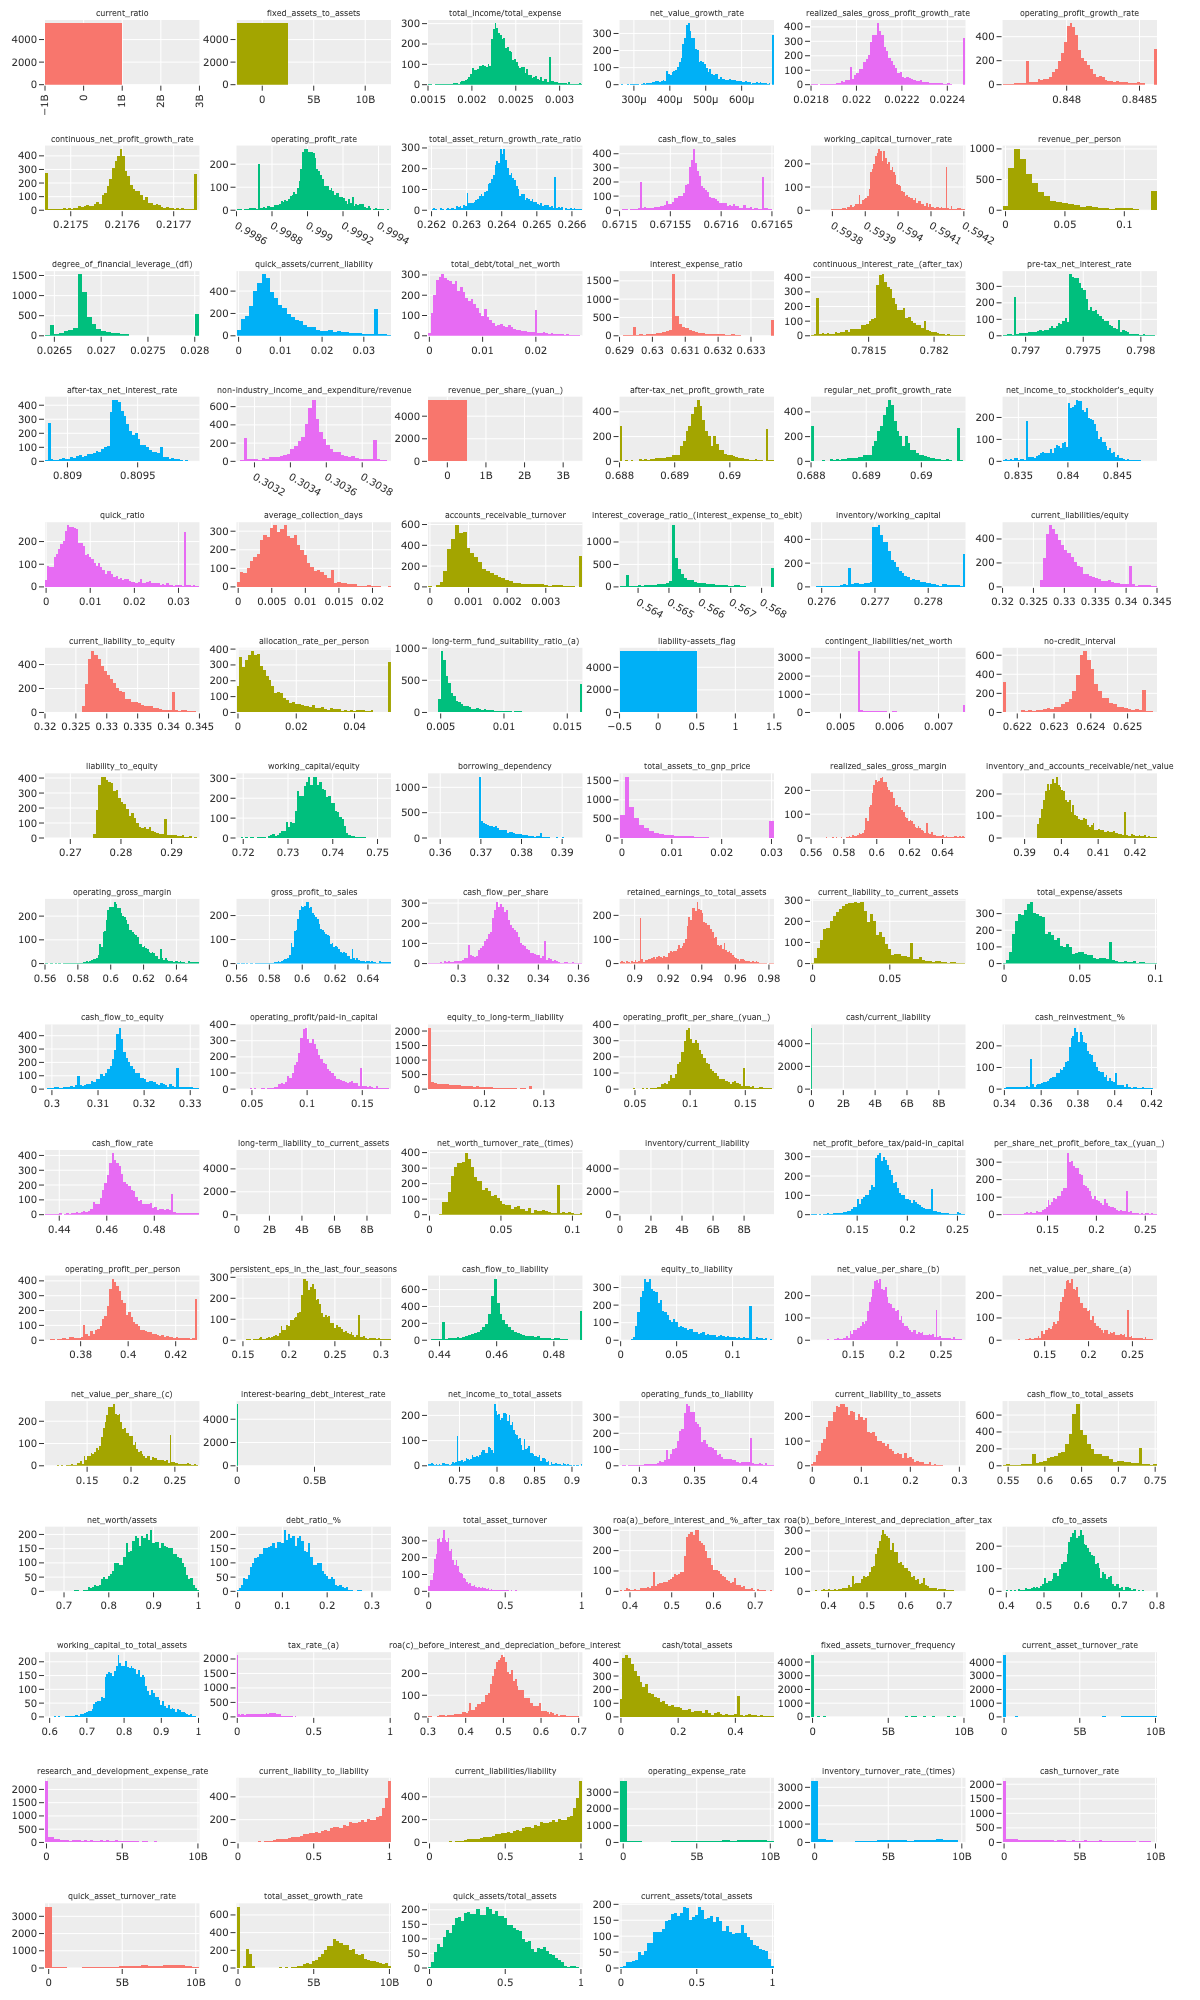

In [16]:
X_train_treated = treat_outliers(X_train,outliers_cols=outliers_cols)
plot_all_dist(X_train_treated,num_cols,show_static_image=True)

Before treating Outliers in Test Data


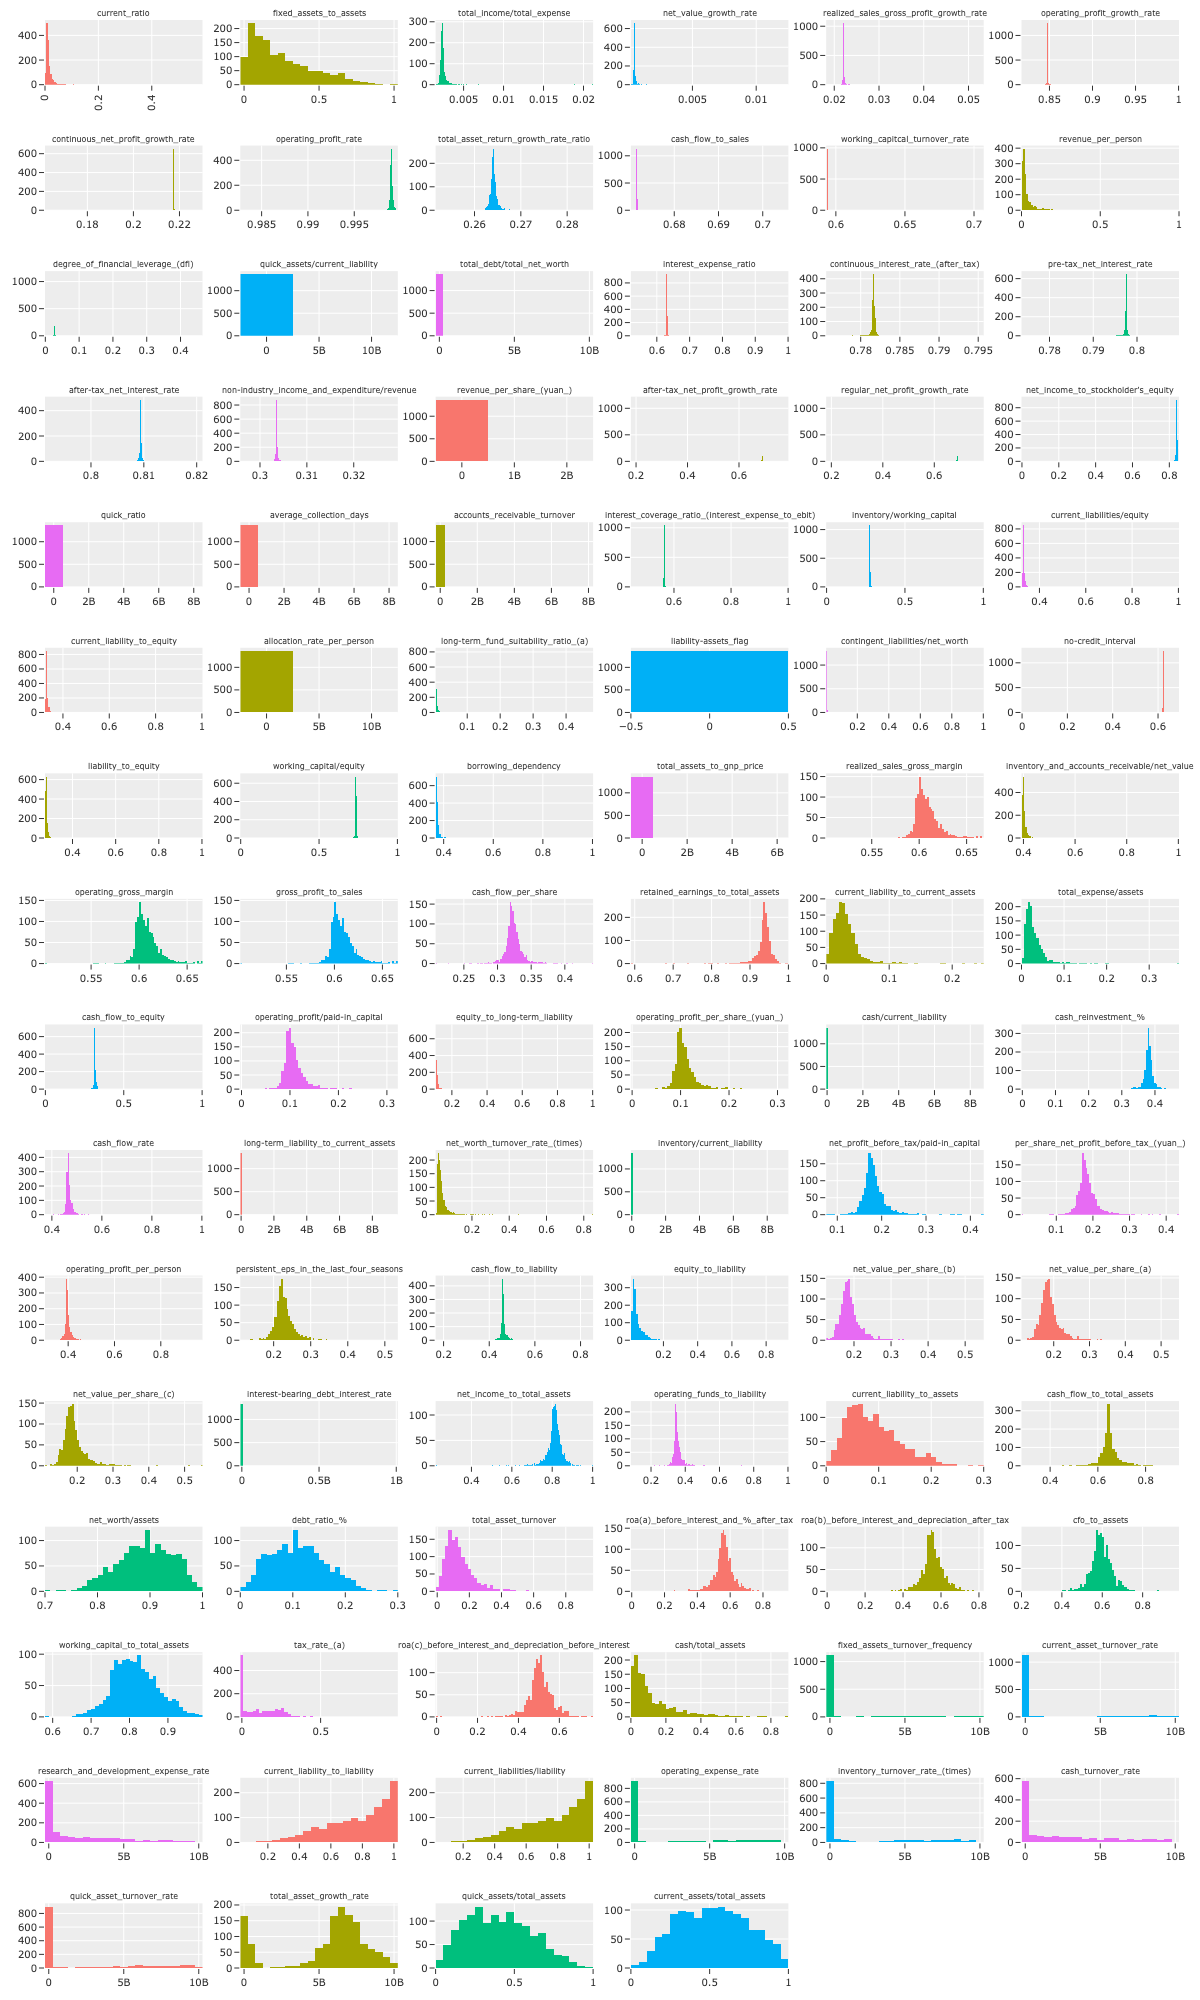

In [17]:
print("Before treating Outliers in Test Data")
plot_all_dist(X_test,num_cols,show_static_image=True)


After treating Outliers in Test Data


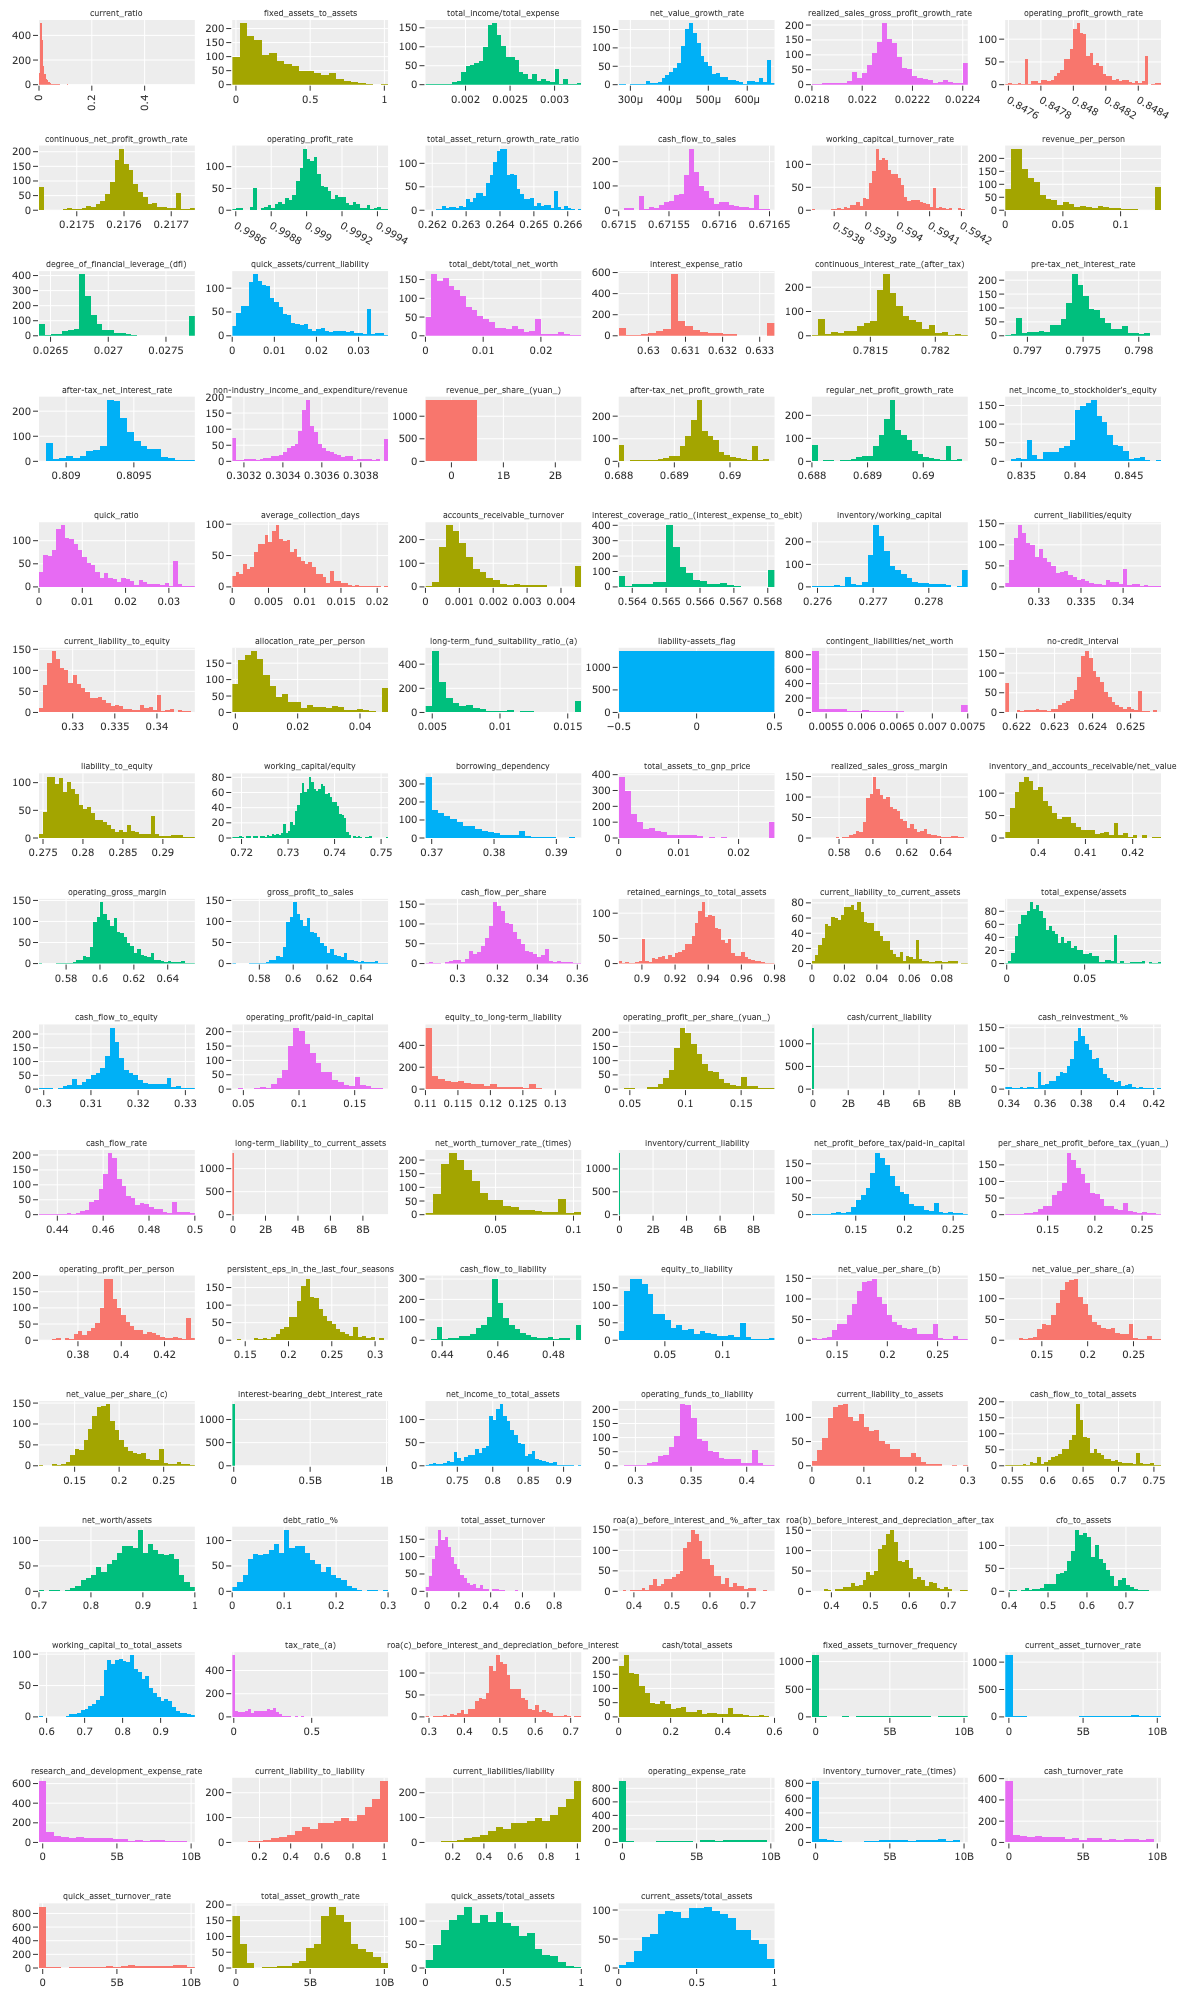

In [18]:
X_test_treated = treat_outliers(X_test,outliers_cols=outliers_cols)
print("After treating Outliers in Test Data")
plot_all_dist(X_test_treated,num_cols,show_static_image=True)


In [19]:
#write data back
training_data = pd.concat([X_train_treated,y_train],axis = 1)\
    .to_csv("../data/training_data.csv",index=False)
test_data = pd.concat([X_test_treated,y_test],axis = 1)\
    .to_csv("../data/testing_data.csv",index=False)

## Correlations
`Pearson Correlation Coefficient` is valid between continuous numerical features. My first step is to compute correlation between continous numerical features and out target. Since the target is a binary numeric value we must compute `Point Biseral Correlation`, which is understood exactly as Pearson and is more suitable for our case. 

* We notice that point biseral correlation suggests that there is no significant correlation between the target and others.
* We can further observe this if we plot the points on a scatter plot by target.

In [20]:
data_num = data_variance.select_dtypes(exclude="category")
data_cat = data_variance.select_dtypes(include="category")

pointbiserial_dict = {}
for c in data_num.columns:
    pointbiserial_dict[c+"_"+target] = pointbiserialr(data_num[c].values, data_num[target].values)[0]
    

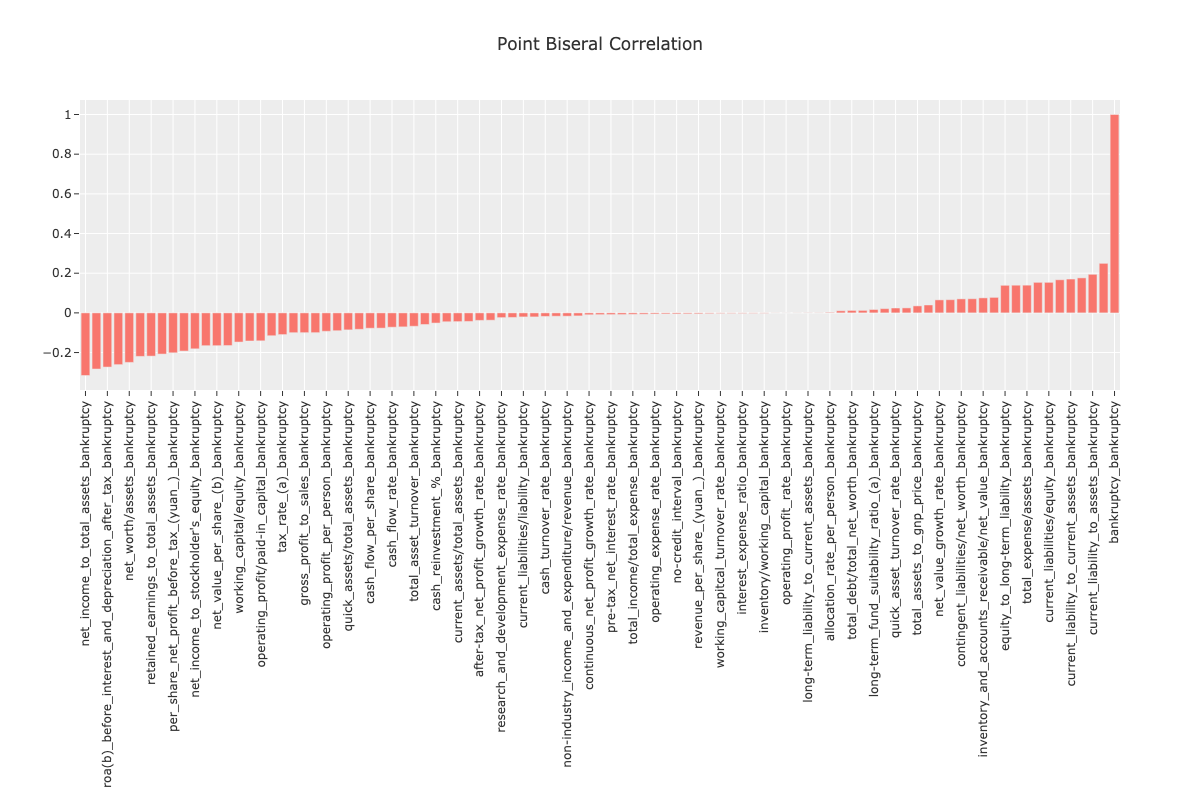

In [21]:
pb_corr = pd.Series(pointbiserial_dict).to_frame(name="correlation").sort_values(by="correlation")

fig = go.Figure([go.Bar(x=pb_corr.index, y=pb_corr.values.flatten())])
fig.update_layout(width=1200, height=800,xaxis_tickangle=-90, title="Point Biseral Correlation")
fig.show("png")


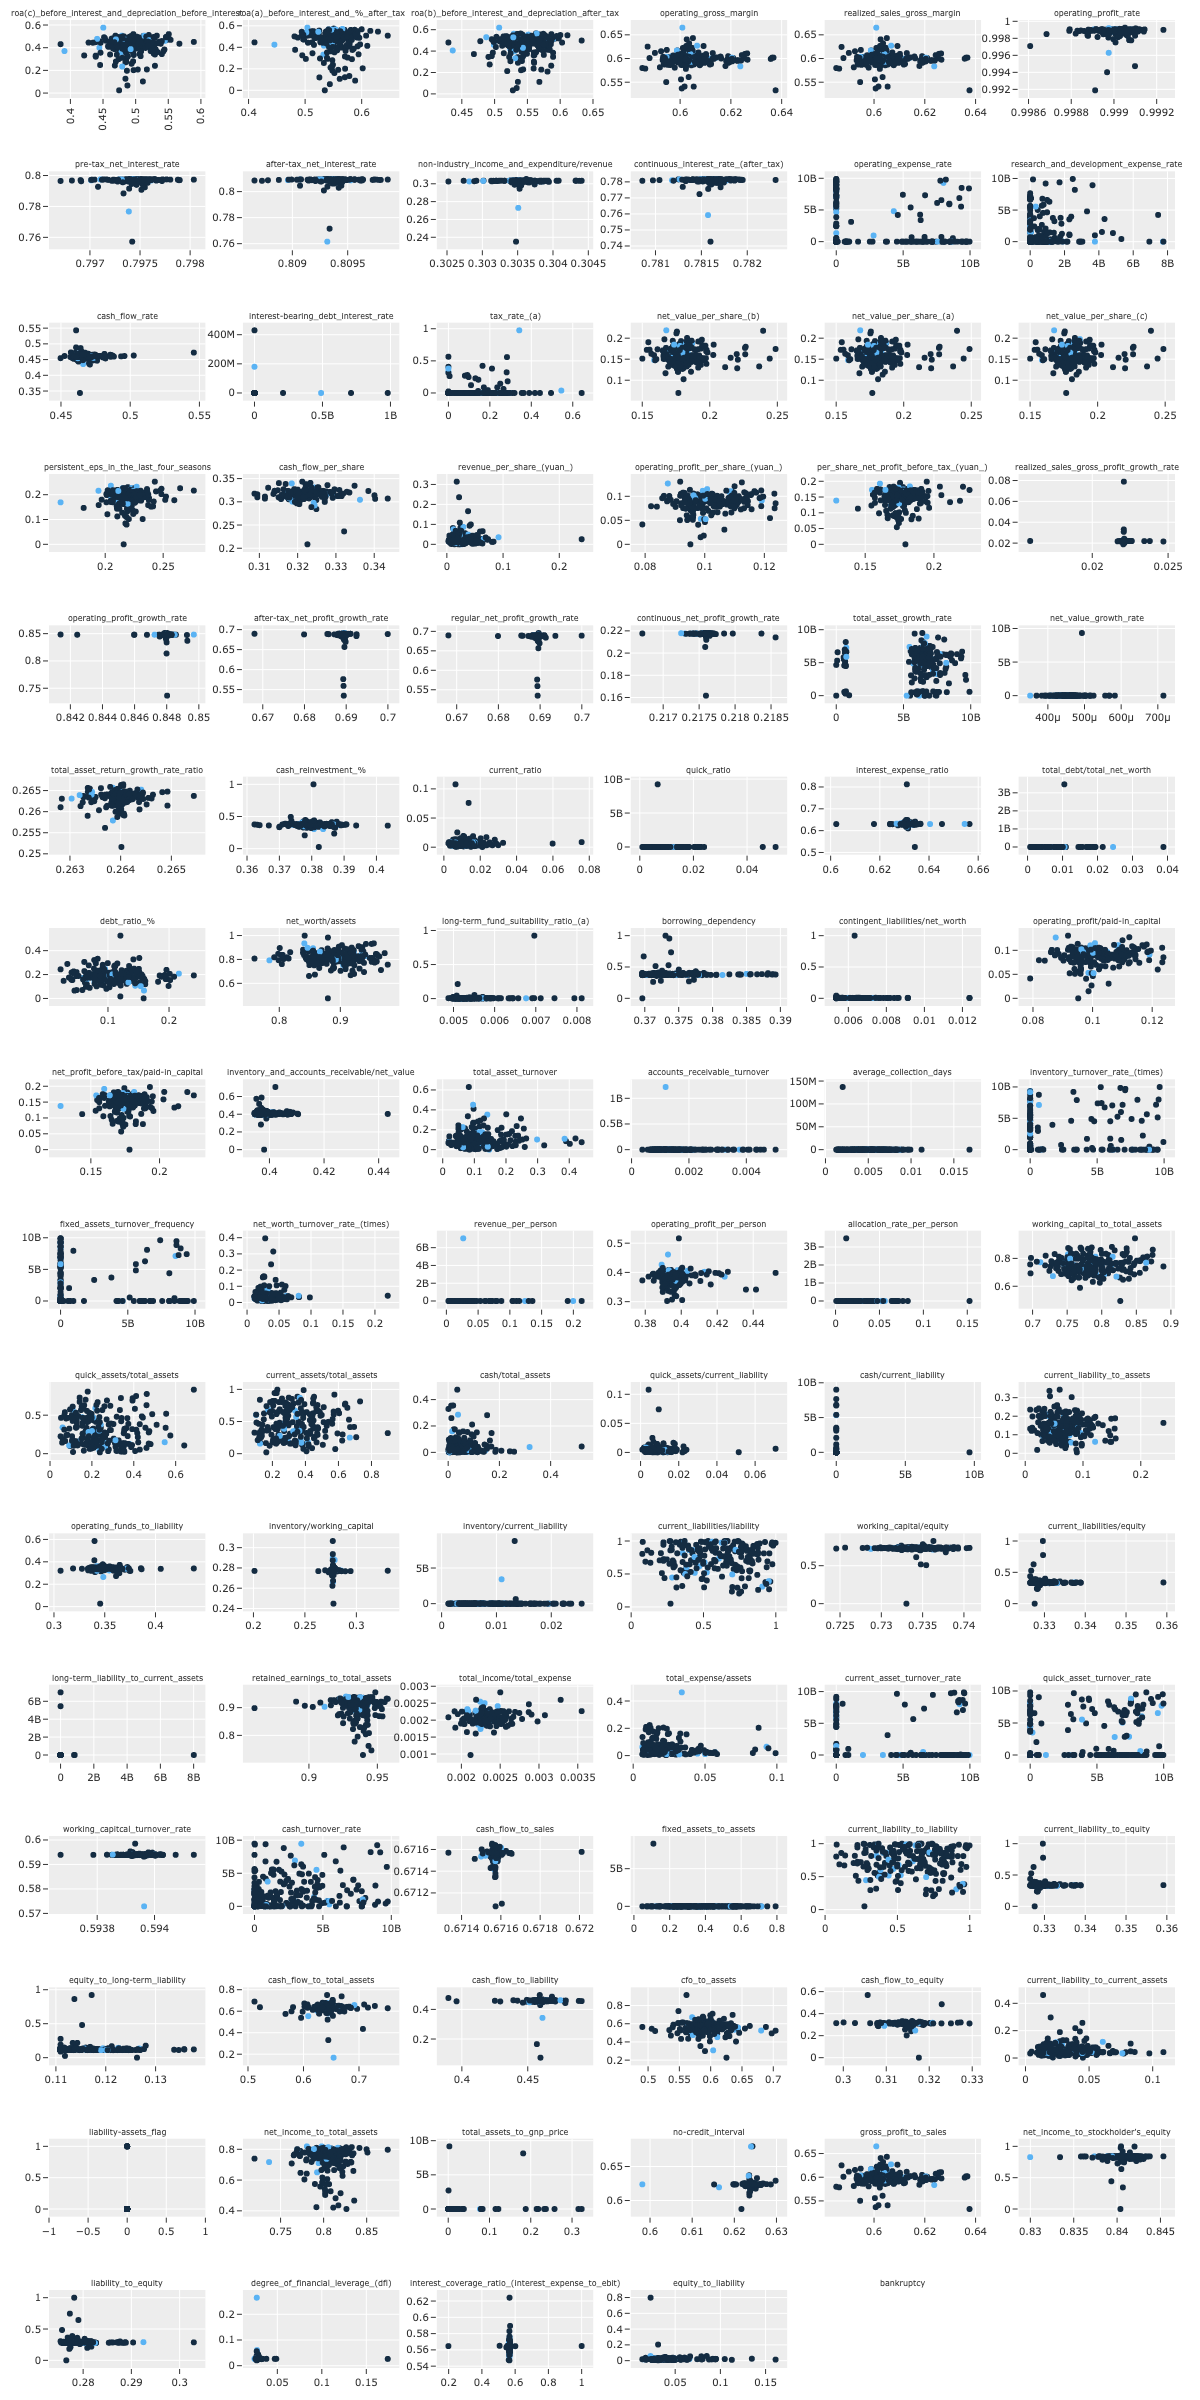

In [22]:
plot_all_scatter(data_variance,show_static_image=True)

The Pearson correlation is further computed between continous numerical features and we can see that there are some highly correlated features. The following plot contains too much of information, lets focus on the features that have their absolute correlation greater than or equal to 90. Correlated features are a problem to Logistic regression due to invertbility issues but for Tree models they are not a problem , also in someway trees also help us discover interactions which classic regression methods can't.

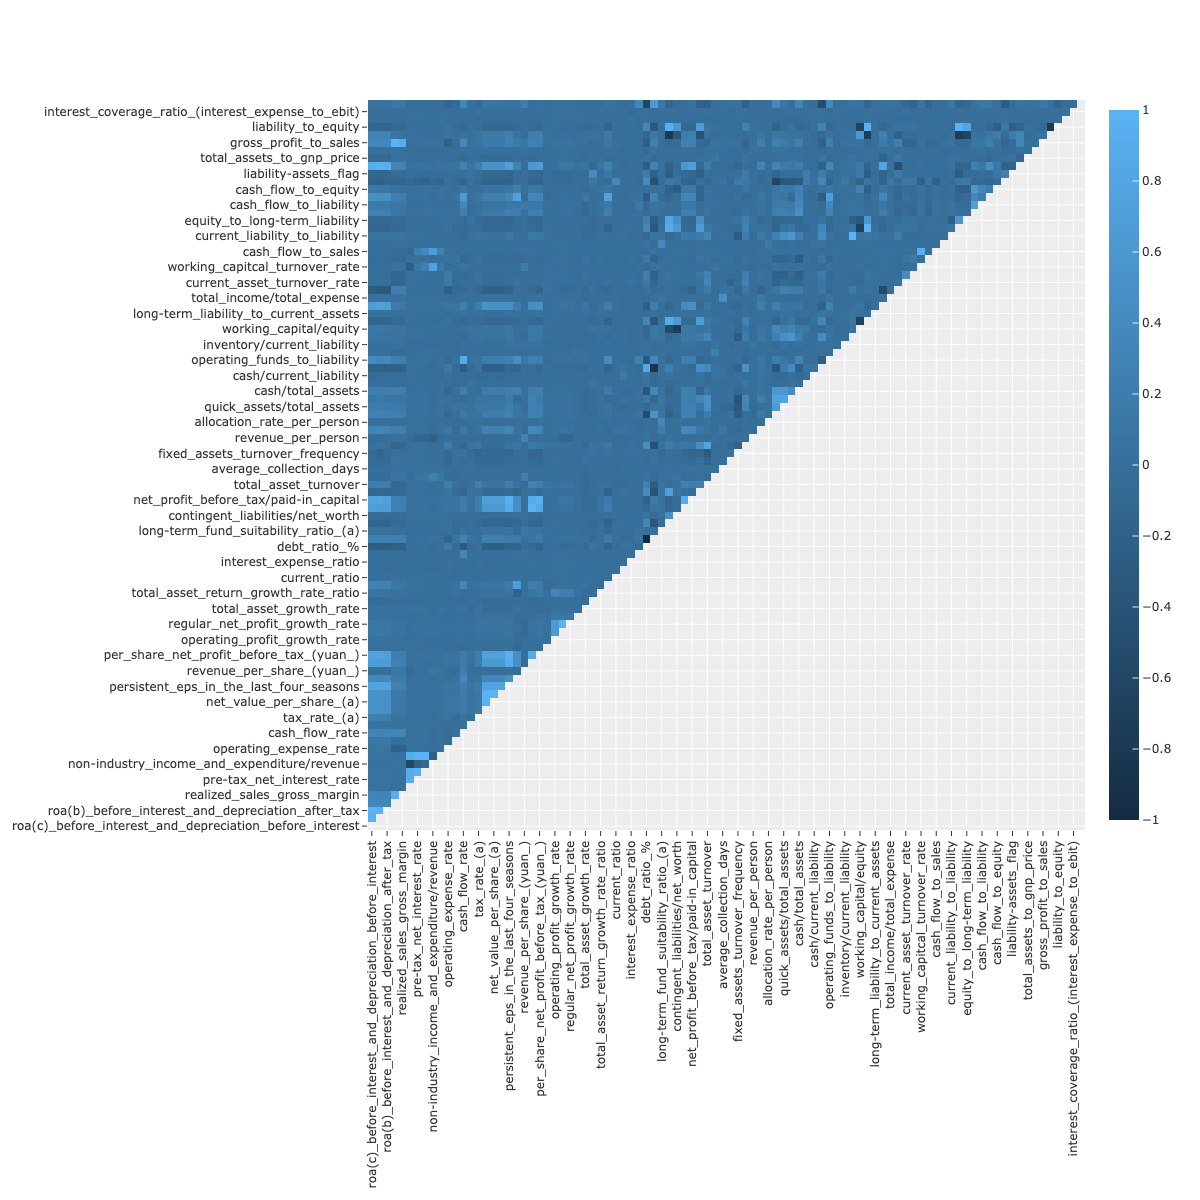

In [23]:
corr = data_num.drop(target, axis=1).corr()
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(corr_mask)

fig = go.Figure(data=go.Heatmap(x=corr.columns,y=corr.index,z=corr.values))
fig.update_layout(width=1200, height=1200,xaxis_tickangle=-90)
fig.show("png")

In [24]:
high_corr = (corr.unstack()
.reset_index()
.dropna()
.rename(columns={"level_0":"feat1","level_1":"feat2",0:"correlation"})
.assign(abs_correlation=lambda x: round(np.abs(x["correlation"]),2)))
high_corr90 = high_corr[high_corr["abs_correlation"]>=0.9]

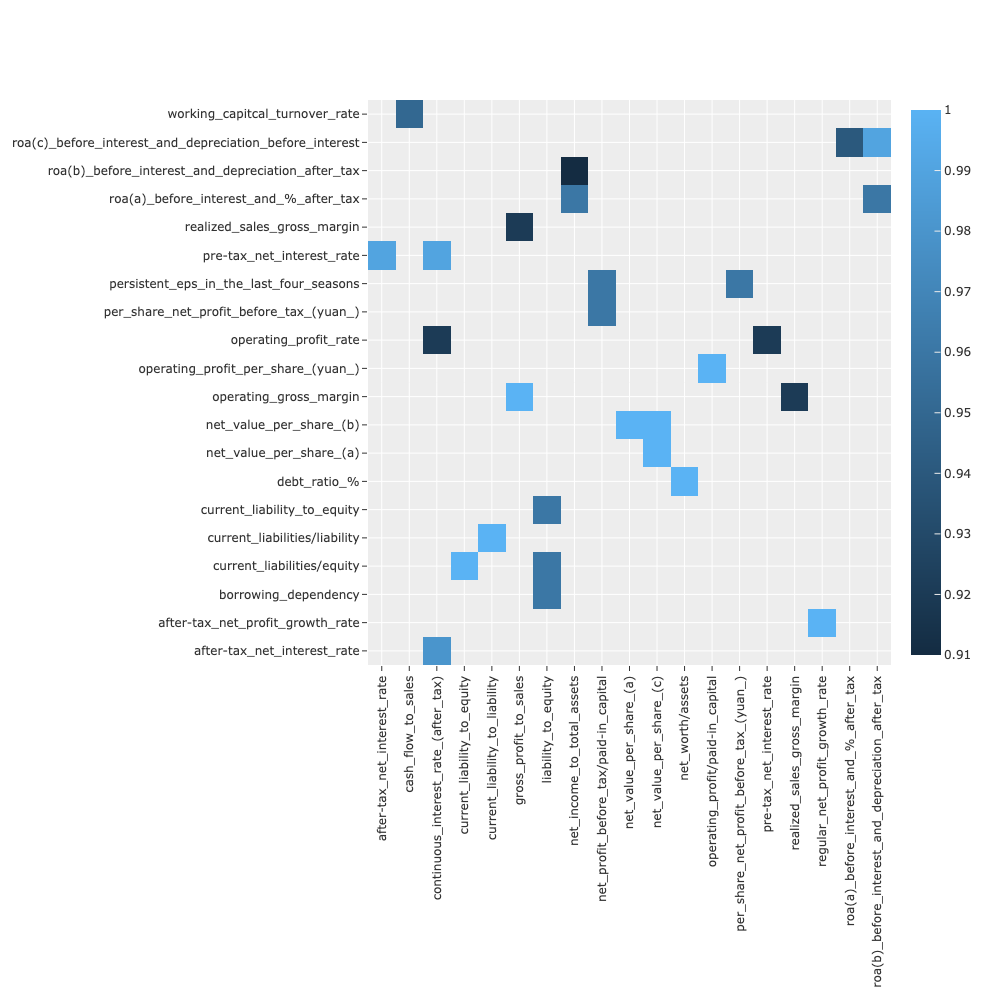

In [25]:
high_corr_pvt=high_corr90.pivot(index="feat1",columns="feat2",values="abs_correlation")
fig = go.Figure(data=go.Heatmap(x=high_corr_pvt.columns,y=high_corr_pvt.index,z=high_corr_pvt.values))
fig.update_layout(width=1000, height=1000,xaxis_tickangle=-90)
fig.show("png")

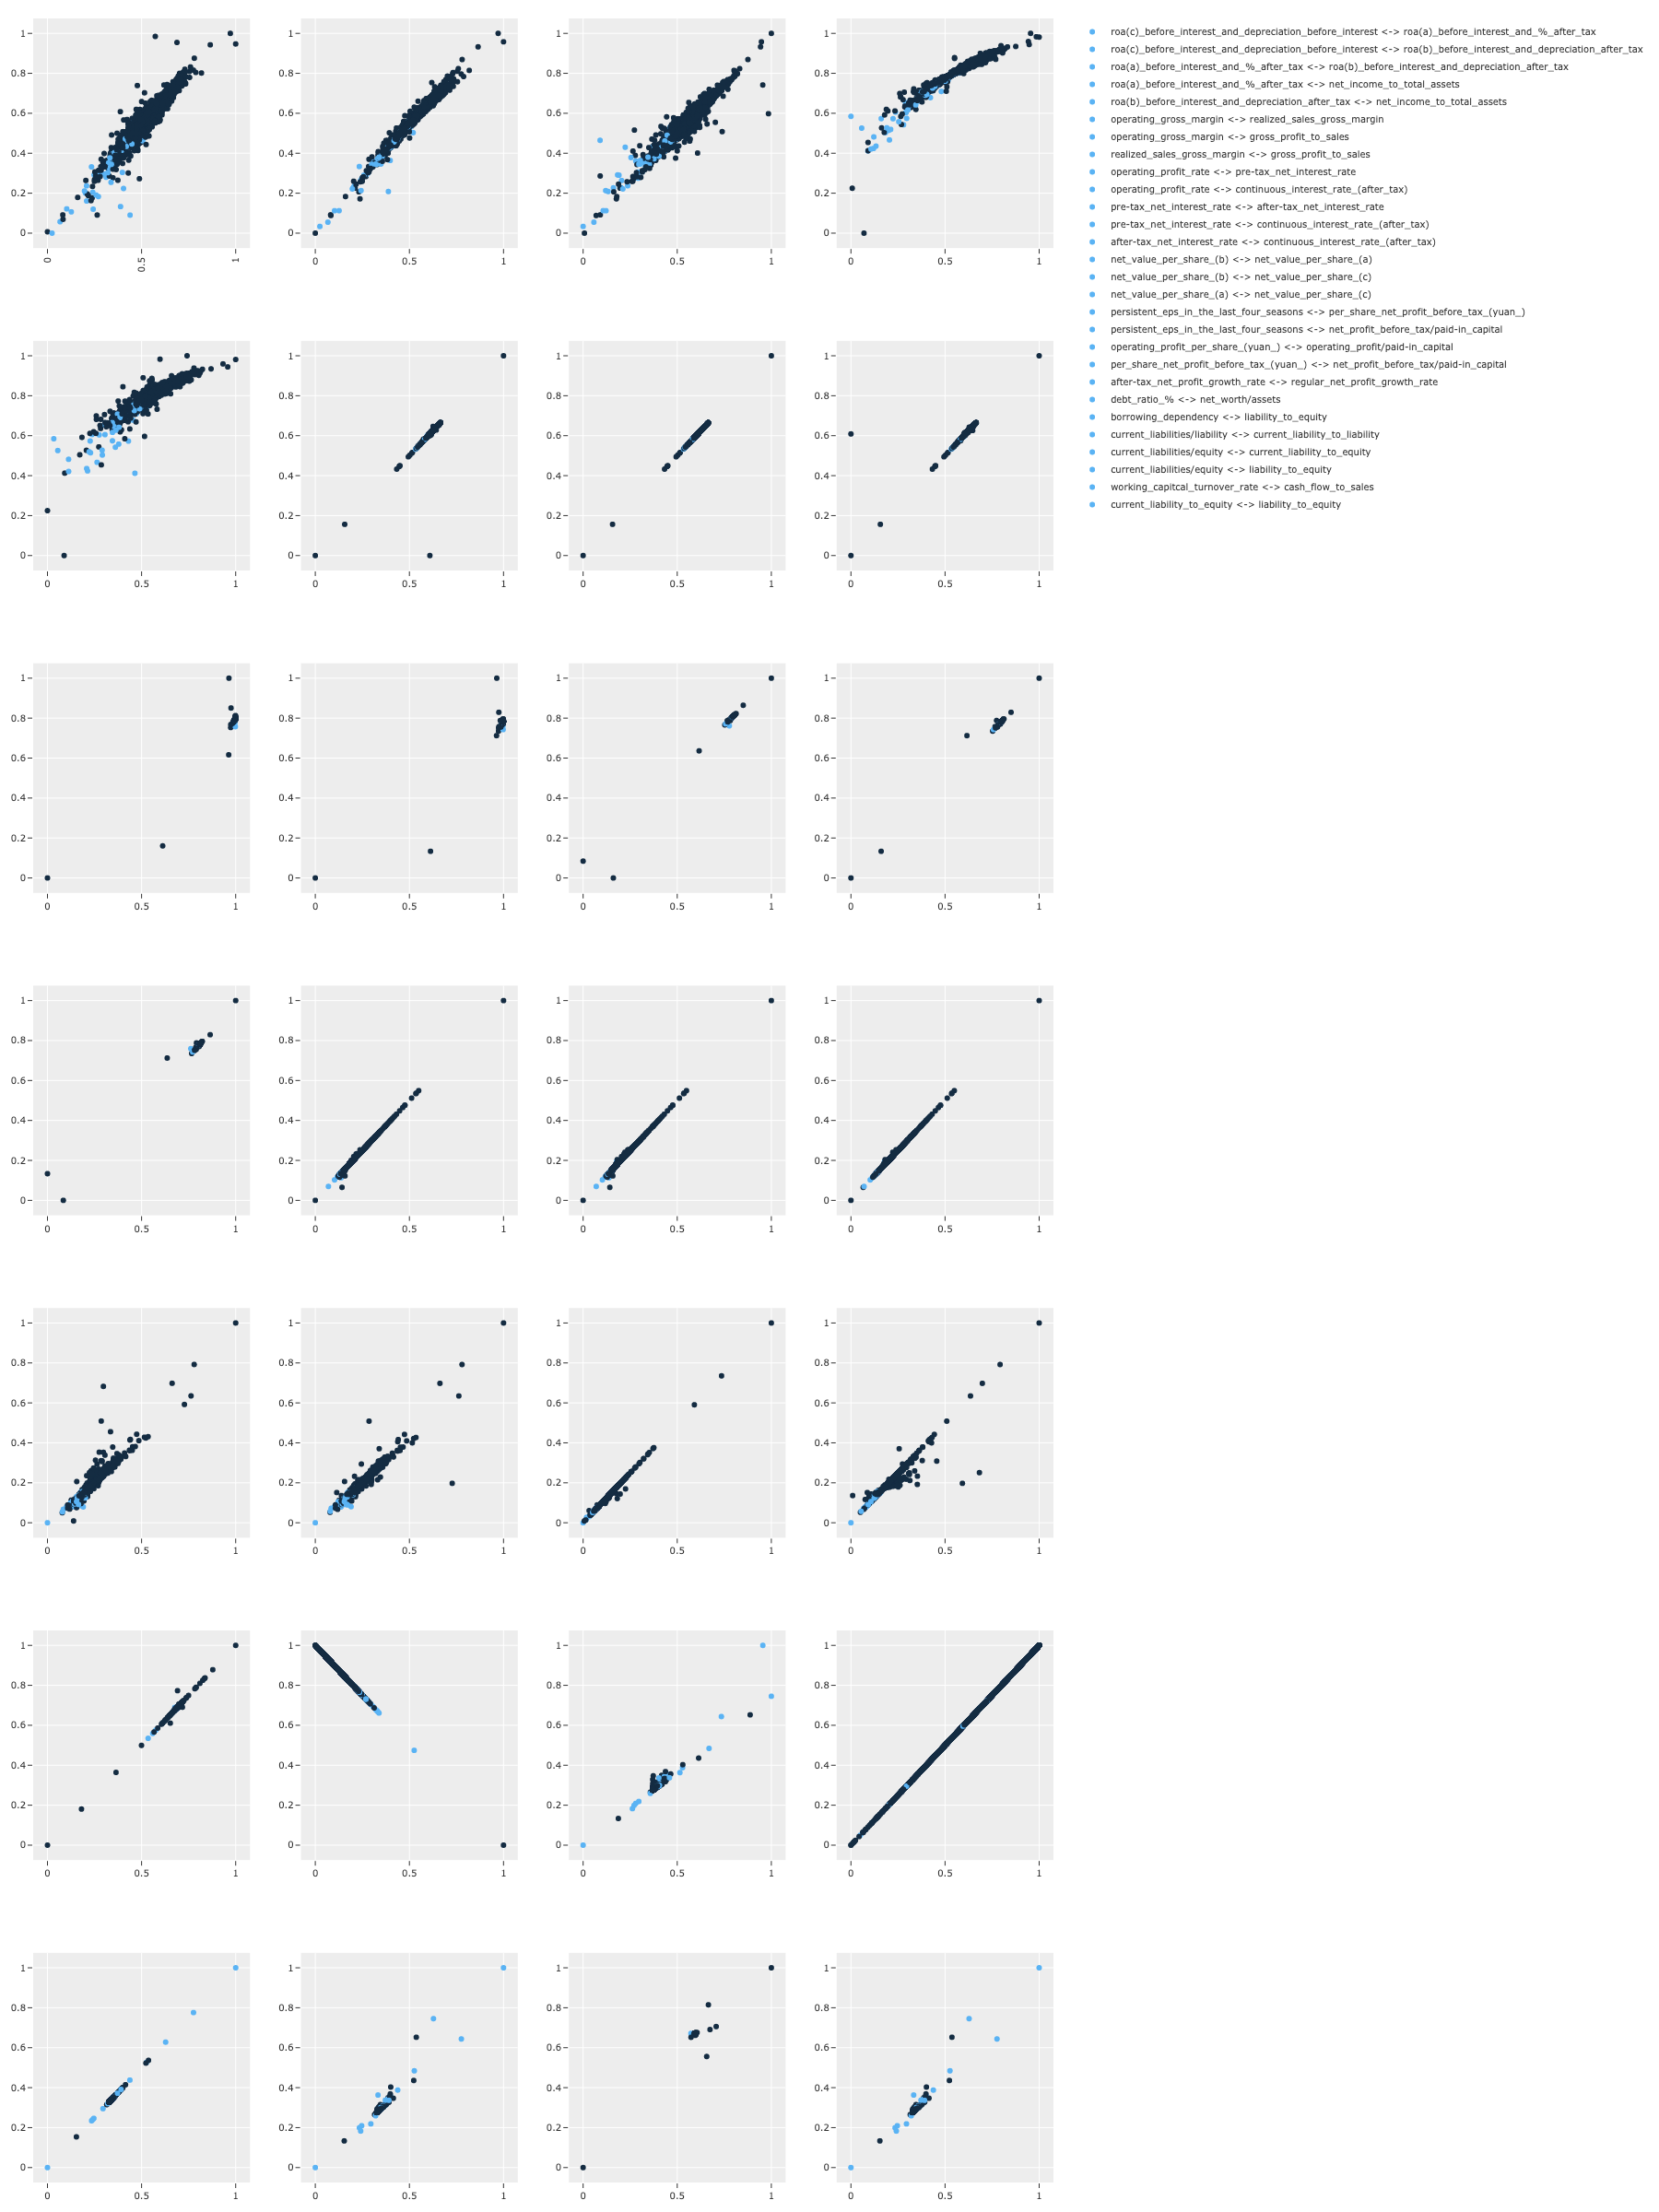

In [26]:
plot_scatter_high_corr(data=data_num,corr_data=high_corr,show_static_image=True)

In [27]:
# saving highly correlated features
high_corr90.to_csv("../data/highcorr90.csv",index=False)